# Game of Thrones NLP Script Analysis

In [1225]:
# GENERAL
import numpy as np
import pandas as pd
import re
import glob
from collections import Counter

# GRAPHING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP
import nltk
from nltk import word_tokenize
from nltk import bigrams
from nltk import trigrams
from nltk import ngrams
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import collocations
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# MODELING
from sklearn import metrics, tree, linear_model, neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

## 00. Research questions

### Can we train a model to identify which GoT character is saying a line from the show?

### Can we use NLP to identify major characters' "catchphrases" (distinct ngrams)?

### What insights can we get from analyzing the sentiment of characters' lines?

### NOTE: all scripts acquired from genius.com (some formatting by hand was required)

## 0. Define major functions
- generate_dialogue_dataframe(path) --> df
- n_most_lines(df, n) --> df_top_n
- add_ngrams(df) --> df
- lines_and_words(df) --> df_by_char
- get_ngrams(df, character="", n=5, season=0, episode=0) --> most_common_ngrams
- add_sentiment_analysis(df) --> df
- graph_sentiment_by_char(df) --> None

### generate_dialogue_dataframe - produces a df of all GoT lines for a path containing scripts

In [1218]:
def generate_dialogue_dataframe(path):
    '''
    For a given path containing files composed of Game of Thrones dialogue, populate_dataframe
    generates a dataframe containing all the characters, the lines they spoke, and the words in each line.
    Also generates season, episode, from file name.
    Returns df['Characters', 'Lines', 'Words', 'Season', 'Episode'], sorted by season, episode
    '''
    # Create df to be returned
    df = pd.DataFrame()

    # Read files
    files = glob.glob(path)
    print(len(files), "read.")

    for file in files:
        # Get season, episode from filename
        episode = int(file[-6:-4])
        season = int(file[-9:-7])
        
        # Load script 
        original_script = open(file).read() # Load files
        script = original_script.split("\n\n") # Create script

        # Populate script lines (only lines containing ":")
        script_lines = []
        for i in range(0,len(script)):
            if ":" in script[i]:
                script_lines.append(script[i])
#         print(file, "\nAll lines:", len(script), "->", "Dialogue lines:", len(script_lines))

        # Remove all parentheses, square brackets from Lines, Characters
        p = 0
        sb = 0
        ast = 0
        for i in range(0, len(script_lines)):
            while "(" in script_lines[i]:
#                 print(script_lines[i])
                script_lines[i] = re.sub("\(.+?\)"," ", script_lines[i])
                p += 1
            while "[" in script_lines[i]:
#                 print(script_lines[i])                
                script_lines[i] = re.sub("\[.+?\]"," ", script_lines[i])
                sb += 1
            while "*" in script_lines[i]:
#                 print(script_lines[i])
                script_lines[i] = re.sub("\*.+?\*"," ", script_lines[i])
                ast += 1  
#         print(p, "parentheses removed.", sb, "square brackets removed.", ast, "*s removed.")

        # Separate lines into character, line
        characters = []
        lines = []
        for line in script_lines:
            if len(line.split(":")) > 1: # If the line can be split...
                temp_name = line.split(":")[0].strip().strip("\n").upper() # Strip leading (& trailing) newlines
                if len(temp_name.split()) < 6: # Subset real names (5 words or less)
                    characters.append(temp_name)
                    lines.append(line.split(":")[1].strip()) # Strip leading (& trailing) whitespace

        # Add characters, lines to dataframe df
        df_temp = pd.DataFrame()
        df_temp["Characters"] = characters
        df_temp["Lines"] = lines
        df_temp["Season"] = [season]*len(lines)
        df_temp["Episode"] = [episode]*len(lines)
        df = df.append(df_temp)

    # df cleanup
    cut_words = ["CUT TO", "EXT", "INT", "INT."] # remove cut_words
    for cut_word in cut_words:
        df = df[df['Characters'] != cut_word]
    df.sort_values(by=['Season', 'Episode'], inplace=True) # Sort by season, episode
    
    # Character consolidation (for characters with different names)
    replacement_name_file = 'GoT_NLP data/replacement_names.txt' # load replacement_name_file (dictionary)
    with open(replacement_name_file,'r') as temp:
        replacement_names = eval(temp.read())
        
    for name in replacement_names:
        df['Characters'] = df['Characters'].replace(name,replacement_names[name])
    
    # Add word count for each line
    word_count = lambda x: len(x.split())
    df['Words'] = df['Lines'].apply(word_count)
    
    return df


### n_most_lines - subset df for n characters with most lines

In [1000]:
def n_most_lines(df, n):
    '''
    Subsets the df by n characters with the most lines
    Returns df_top_n
    '''
    top_n_characters = pd.DataFrame(data=df['Characters'].value_counts()).index[0:n] # Get list of top n characters
    df_top_n = pd.DataFrame(data=df[df['Characters'].isin(top_n_characters)]) # Subset df for top n characters

    return df_top_n

### Add most common n-grams for each character to the dataframe

In [1430]:
def add_ngrams(df):
    '''
    Adds n-gram columns to df. Generates them from df['Lines'].
    NOTE: unigram column has stopwords removed
    Returns updated df
    '''
    stopwords = list(STOP_WORDS) # Generate list of stopwords for unigrams

    # Add empty unigram, bigram, trigram, fourgram, and fivegram columns to the df
    df["Unigrams"], df["Bigrams"], df["Trigrams"], df['Fourgrams'], df['Fivegrams'] = "", "", "", "", ""
    all_unigrams, all_bigrams, all_trigrams, all_fourgrams, all_fivegrams = [], [], [], [], []
    df['Unigram_dict'], all_unigram_dicts = "", []
    
    # Use NLTK to find all bigrams, trigrams, fourgrams, fivegrams for each line
    for i in df['Lines']:

        i = re.sub("[^A-Za-z ]", "", i) # Removes all non-letters (including apostrophes), non-spaces from text
        i = i.lower()
        
        unigrams = [word for word in i.split() if word not in stopwords] # 1-grams
        all_unigrams.append(list(unigrams))
        all_bigrams.append(list(bigrams(i.split()))) # 2-grams
        all_trigrams.append(list(trigrams(i.split()))) # 3-grams
        all_fourgrams.append(list(ngrams(i.split(), 4))) # 4-grams
        all_fivegrams.append(list(ngrams(i.split(), 5))) # 5-grams
        
        unigram_dict = {}
        for unigram in set(unigrams):
            unigram_dict[unigram] = unigrams.count(unigram)
        all_unigram_dicts.append(unigram_dict)
    
    # Populate df columns with n-grams
    df['Unigrams'], df["Bigrams"], df["Trigrams"], df["Fourgrams"], df["Fivegrams"] = all_unigrams, all_bigrams,\
        all_trigrams, all_fourgrams, all_fivegrams
    df['Unigram_dict'] = all_unigram_dicts
    
    return df

In [1431]:
temp = add_ngrams(df)
temp.head()

,Characters,Lines,Season,Episode,Words,Polarity,Positive,Negative,Neutral,Compound,Unigrams,Bigrams,Trigrams,Fourgrams,Fivegrams,Unigram_dict
0,WAYMAR ROYCE,What d’you expect? They’re savages. One lot st...,1,1,24,-0.125,0.000,0.242,0.758,-0.772,"[dyou, expect, theyre, savages, lot, steals, g...","[(what, dyou), (dyou, expect), (expect, theyre...","[(what, dyou, expect), (dyou, expect, theyre),...","[(what, dyou, expect, theyre), (dyou, expect, ...","[(what, dyou, expect, theyre, savages), (dyou,...","{'ripping': 1, 'lot': 2, 'know': 1, 'savages':..."
1,WILL,I’ve never seen wildlings do a thing like this...,1,1,21,0.000,0.227,0.000,0.773,0.612,"[ive, seen, wildlings, thing, like, ive, seen,...","[(ive, never), (never, seen), (seen, wildlings...","[(ive, never, seen), (never, seen, wildlings),...","[(ive, never, seen, wildlings), (never, seen, ...","[(ive, never, seen, wildlings, do), (never, se...","{'wildlings': 1, 'thing': 2, 'like': 2, 'ive':..."
2,WAYMAR ROYCE,How close did you get?,1,1,5,0.000,0.000,0.000,1.000,0.000,[close],"[(how, close), (close, did), (did, you), (you,...","[(how, close, did), (close, did, you), (did, y...","[(how, close, did, you), (close, did, you, get)]","[(how, close, did, you, get)]",{'close': 1}
3,WILL,Close as any man would.,1,1,5,0.000,0.000,0.000,1.000,0.000,"[close, man]","[(close, as), (as, any), (any, man), (man, wou...","[(close, as, any), (as, any, man), (any, man, ...","[(close, as, any, man), (as, any, man, would)]","[(close, as, any, man, would)]","{'close': 1, 'man': 1}"
4,GARED,We should head back to the wall.,1,1,7,0.000,0.000,0.000,1.000,0.000,"[head, wall]","[(we, should), (should, head), (head, back), (...","[(we, should, head), (should, head, back), (he...","[(we, should, head, back), (should, head, back...","[(we, should, head, back, to), (should, head, ...","{'head': 1, 'wall': 1}"


### lines_and_words - create a dataframe of total lines, total words, and unique words grouped by character

In [1002]:
def lines_and_words(df):
    '''
    Produces a df with line and word counts for each character.
    If add_n_grams has been run, populates 'Unique_words', 'Num_unique_words', and Unique_words_per_line columns
    returns df_by_char, sorted by number of lines (descending)
    '''
    # Get characters for indexing dataframes
    char_index = df.groupby(by=['Characters']).sum().index.values
    
    # Get total lines for each character
    df_lines_by_char = pd.DataFrame(data=df['Characters'].value_counts())
    df_lines_by_char.rename(columns={"Characters":"Total Lines"}, inplace=True)

    # Get total words for each character
    df_words_by_char = pd.DataFrame(data = df.groupby(by=['Characters'])['Words'].sum().values,\
                        index=char_index, columns=["Total Words"])
        
    # Set meaningful unique_words, num_unique_words
    unigrams = df.groupby(by=['Characters'])['Unigrams'].sum().values
    unique_unigrams = [list(set(unigrams[i])) for i in range(0, len(unigrams))]
    num_unique_unigrams = [len(words) for words in unique_unigrams]
        
    # Create dataframes for unique_words_by_char, num_unique_words_by_char
    df_unique_unigrams = pd.DataFrame(data = np.array(unique_unigrams), index=char_index, columns=["Unique_unigrams"])
    df_num_unique_unigrams = pd.DataFrame(data = num_unique_unigrams, index = char_index,\
                            columns=['Num_unique_unigrams'])
    
    # Create df_by_char
    df_by_char = pd.concat([df_lines_by_char, df_words_by_char, df_unique_unigrams, df_num_unique_unigrams],\
                                   axis=1, sort=True).sort_values(by="Total Lines", ascending=False)
    
    # Get words per line for each character
    df_by_char['Words per Line'] = df_by_char['Total Words'].values/\
        df_by_char['Total Lines'].values
    df_by_char['Words per Line'] = round(df_by_char['Words per Line'], 0)
    
    return df_by_char

### get_ngrams - subset most n-grams by character, season/episode, or entire df

In [855]:
def get_ngrams(df, character="", n=5, season=0, episode=0):
    '''
    Gets n most common n-grams for a given character, season/episode, or the whole df
    If no character provided, gives all n-grams for the entire df.
    Returns array of n n-grams.
    '''
    # Subset by season, episode (optional)
    if season !=0 and episode !=0:
        df = df[df['Season']==season]
        df = df[df['Episode']==episode]
    
    # Subset by character (optional)
    if character != "": # If a character is specified, subset the df by character
        unigrams = df[df['Characters']==character]["Unigrams"].values
        bigrams = df[df['Characters']==character]["Bigrams"].values
        trigrams = df[df['Characters']==character]["Trigrams"].values
        fourgrams = df[df['Characters']==character]["Fourgrams"].values
        fivegrams = df[df['Characters']==character]["Fivegrams"].values

    else: # If no character is specified
        unigrams, bigrams, trigrams, fourgrams, fivegrams = df['Unigrams'].values, df['Bigrams'].values,\
            df['Trigrams'].values, df['Fourgrams'].values, df['Fivegrams'].values

    # Generate lists of n-grams for all rows in the subsetted df
    all_unigrams, all_bigrams, all_trigrams, all_fourgrams, all_fivegrams = [], [], [], [], []
    all_unigrams = [n_gram for n_gram_list in unigrams for n_gram in n_gram_list]
    all_bigrams = [n_gram for n_gram_list in bigrams for n_gram in n_gram_list]
    all_trigrams = [n_gram for n_gram_list in trigrams for n_gram in n_gram_list]
    all_fourgrams = [n_gram for n_gram_list in fourgrams for n_gram in n_gram_list]
    all_fivegrams = [n_gram for n_gram_list in fivegrams for n_gram in n_gram_list]
    
    # Get counts for all n-grams
    unigram_counter, bigram_counter, trigram_counter, fourgram_counter, fivegram_counter = Counter(all_unigrams),\
           Counter(all_bigrams), Counter(all_trigrams), Counter(all_fourgrams), Counter(all_fivegrams)

    most_common_ngrams = np.array([unigram_counter.most_common(n), bigram_counter.most_common(n), trigram_counter.most_common(n),\
        fourgram_counter.most_common(n), fivegram_counter.most_common(n)])
    
    return most_common_ngrams

### add_sentiment_analysis - adds TextBlob, Vader sentiment for each line

In [856]:
def add_sentiment_analysis(df):
    """
    Takes in a df containing "Lines" and performs sentiment analysis on each block of text.
    Returns an updated df with four sentiment (Vader) columns for each line.
    Saves the updated df to file
    """

    # LOAD NLP MODEL
#     nlp = spacy.load('en_core_web_lg')

    # Add four NLP coloums
    if "Compound" not in df.columns:
        df['Polarity'] = None
        df['Positive'] = None
        df['Negative'] = None
        df['Neutral'] = None
        df['Compound'] = None
    
    # Instantiate Vader analyzer
    analyzer = SentimentIntensityAnalyzer()
        
    # Populate polarity (TextBlob)
    pol = lambda x: round(TextBlob(x).sentiment.polarity,3)
    
    df['Polarity'] = df['Lines'].apply(pol)

    # Populate Vader sentiment columns
    pos = lambda x: round(analyzer.polarity_scores(x)['pos'],3)
    neg = lambda x: round(analyzer.polarity_scores(x)['neg'],3)
    neu = lambda x: round(analyzer.polarity_scores(x)['neu'],3)
    compound = lambda x: round(analyzer.polarity_scores(x)['compound'],3)

    df['Positive'] = df['Lines'].apply(pos)
    df['Negative'] = df['Lines'].apply(neg)    
    df['Neutral'] = df['Lines'].apply(neu)
    df['Compound'] = df['Lines'].apply(compound)
    
    # Save to file
    df.to_csv("df_backup_GoT.csv")
    print(f"Successfully performed sentiment analysis.")
    return df

### graph_sentiment_by_char - graphs sentiment for each character

In [ ]:
def graph_sentiment_by_char(df):
    '''
    Graphs Textblob, Vader sentiments for 
    Returns nothing
    '''
    # GRAPH TEXTBLOB VALUES    
    df.sort_values(by='Polarity', ascending=True, inplace=True) # Sort df by Textblob values
    characters = df.index.values
 
    plt.figure(figsize=(12,20))
    plt.title("TextBlob sentiments")
    plt.barh(width=df['Polarity'].values, y=characters)
    plt.show
    
    # GRAPH VADER VALUES
    df.sort_values(by='Compound', ascending=True, inplace=True) # Sort df by Textblob values
    characters = df.index.values

    plt.figure(figsize=(12,20))
    plt.title("VADER sentiments (Compound)")
    plt.barh(width=df['Compound'].values, y=characters, color="blue")
    plt.show
    
    plt.figure(figsize=(12,20))
    plt.title("VADER sentiments (Positive/Negative)")
    plt.barh(width=-df['Negative'].values, y=characters, color="red")
    plt.barh(width=df['Positive'].values, y=characters, color="green")
    plt.show

    return None

## 1. Run functions, populate dataframes

Let's create/populate our dataframe of all lines (df) and grouped by character (df_by_char)

In [1252]:
# Populate df for all script files in path - save data 
path = 'GoT_NLP data/GoT_S**E**.txt'

df = generate_dialogue_dataframe(path) # Create df, populate from files
df = add_sentiment_analysis(df) # Add sentiment for each line in df
df = add_ngrams(df) # Add n-grams to df

print("df shape:", df.shape)
df.head(3)

73 read.
Successfully performed sentiment analysis.
df shape: (24895, 15)


,Characters,Lines,Season,Episode,Words,Polarity,Positive,Negative,Neutral,Compound,Unigrams,Bigrams,Trigrams,Fourgrams,Fivegrams
0,WAYMAR ROYCE,What d’you expect? They’re savages. One lot st...,1,1,24,-0.125,0.000,0.242,0.758,-0.772,"[dyou, expect, theyre, savages, lot, steals, g...","[(what, dyou), (dyou, expect), (expect, theyre...","[(what, dyou, expect), (dyou, expect, theyre),...","[(what, dyou, expect, theyre), (dyou, expect, ...","[(what, dyou, expect, theyre, savages), (dyou,..."
1,WILL,I’ve never seen wildlings do a thing like this...,1,1,21,0.000,0.227,0.000,0.773,0.612,"[ive, seen, wildlings, thing, like, ive, seen,...","[(ive, never), (never, seen), (seen, wildlings...","[(ive, never, seen), (never, seen, wildlings),...","[(ive, never, seen, wildlings), (never, seen, ...","[(ive, never, seen, wildlings, do), (never, se..."
2,WAYMAR ROYCE,How close did you get?,1,1,5,0.000,0.000,0.000,1.000,0.000,[close],"[(how, close), (close, did), (did, you), (you,...","[(how, close, did), (close, did, you), (did, y...","[(how, close, did, you), (close, did, you, get)]","[(how, close, did, you, get)]"


In [1253]:
# Save df to csv
df.to_csv('GoT_NLP data/GoT_lines.csv', index=False )

In [1254]:
# Create df_by_char from df
df_by_char = lines_and_words(df)
df_by_char.head()

,Total Lines,Total Words,Unique_unigrams,Num_unique_unigrams,Words per Line
TYRION,1832,26759,"[savior, choice, actual, bound, ones, stokewor...",3006,15.0
JON,1186,12342,"[choice, ones, everone, years, collapses, end,...",1434,10.0
DAENERYS,1069,12610,"[choice, actual, cared, ones, unhurt, years, e...",1565,12.0
CERSEI,1036,14890,"[choice, cared, actual, ones, years, destructi...",1994,14.0
JAIME,979,11745,"[rags, bound, choice, ones, cared, years, dull...",1761,12.0


In [1255]:
# Save df_by_char to csv
df_by_char.to_csv('GoT_NLP data/GoT_by_char.csv')

### Sample questions

Although Jon has more lines and words than Cersei, she has a greater vocabulary. Which words does Cersei use that Jon doesn't?

In [1285]:
jon_unigrams = df_by_char['Unique_unigrams'].loc['JON']
cersei_unigrams = df_by_char['Unique_unigrams'].loc['CERSEI']

# Words Jon says but Cersei doesn't
jon_words = [unigram for unigram in jon_unigrams if unigram not in cersei_unigrams] # Jon - Cersei

# Words Cersei says but Jon doesn't
cersei_words = [unigram for unigram in cersei_unigrams if unigram not in jon_unigrams] # Cersei - Jon

In [1302]:
from nltk.text import Text

cersei_lines = df[df['Characters']=='CERSEI']['Lines'].values

word = "and"
# for line in cersei_lines:
nlp_line = Text(cersei_lines)
nlp_line.concordance(word)

<Text: And you never worry about anything. When we were seven, you jumped off the cliffs as Casterly Rock. One hundred foot drop into the water. And you were never afraid. What if Jon Arryn told someone? My husband. You should be the Hand of the king. We’ve been riding for a month, my love. Surely the dead can wait. Where is our brother? Go find the little beast. Yes. Lovely country. Hello, little dove. But you are a beauty. How old are you?...>
no matches


In [1432]:
def unigram_difference(name1, name2):
    '''
    Creates a sorted list of unigrams used in lines by name1, but not name2.
    Returns unigram_counts_sorted
    '''
    name1_unigrams = df_by_char['Unique_unigrams'].loc[name1]
    name2_unigrams = df_by_char['Unique_unigrams'].loc[name2]
    unigrams_by_line = df[df['Characters']==name1]['Unigrams'].values

    # Unigrams said by name1, but not name2
    unigrams = [unigram for unigram in name1_unigrams if unigram not in name2_unigrams]
#     print(unigrams)
    
    # Get dictionary of unigram counts
    unigram_counts = {}
    for word in unigrams:
        counter = 0
        for group in unigrams_by_line:
            if word in group:
                counter += 1
        unigram_counts[word] = counter

    # Sort unigram counts
    unigram_counts_sorted = sorted((value, key) for (key,value) in unigram_counts.items())
    unigram_counts_sorted.reverse()
    print(unigram_counts_sorted)
    
    return unigram_counts_sorted

In [1433]:
name2 = 'JON'
name1 = 'CERSEI'
unigram_counts_sorted = unigram_difference(name1, name2)

[(25, 'jaime'), (11, 'tyrell'), (11, 'sparrow'), (10, 'margaery'), (10, 'bank'), (9, 'trial'), (9, 'gregor'), (9, 'capital'), (8, 'sept'), (8, 'husband'), (7, 'whores'), (7, 'myrcella'), (7, 'master'), (7, 'loras'), (7, 'euron'), (7, 'dove'), (7, 'dorne'), (7, 'beautiful'), (6, 'wedding'), (6, 'tommen'), (6, 'septon'), (6, 'rule'), (6, 'mind'), (6, 'marry'), (6, 'lovely'), (6, 'idea'), (6, 'highgarden'), (6, 'future'), (6, 'confess'), (5, 'tyrells'), (5, 'targaryens'), (5, 'story'), (5, 'siege'), (5, 'shipped'), (5, 'qyburn'), (5, 'prince'), (5, 'oh'), (5, 'oberyn'), (5, 'lie'), (5, 'instead'), (5, 'grand'), (5, 'felt'), (5, 'eldest'), (5, 'concern'), (5, 'beast'), (4, 'wonder'), (4, 'unsullied'), (4, 'turned'), (4, 'sweet'), (4, 'stupid'), (4, 'started'), (4, 'stands'), (4, 'shocked'), (4, 'shame'), (4, 'service'), (4, 'sea'), (4, 'poor'), (4, 'pain'), (4, 'paid'), (4, 'mouth'), (4, 'morning'), (4, 'lion'), (4, 'lancel'), (4, 'hundreds'), (4, 'holiness'), (4, 'guest'), (4, 'fanatics')

Interesting - many of the names referenced by Jon/Cersei but not the other are names - as one might expect.

## 2 Preliminary analysis: lines and words by character

### Functions for analysis
- n_most_lines(df, n) --> df_top_n
- get_ngrams(df, character="", n=5, season=0, episode=0) --> most_common_ngrams
- graph_sentiment_by_char(df) --> None

Now we have a df consisting of character names and lines for each character. Let's get a sorted series of line counts for each character. Let's only consider the top 100 characters with the most lines

Let's also subset the df for the top 100 characters with the most lines.

In [1003]:
# Apply n_most_lines, lines_and_words, to generate a df of the characters with the most lines. 
max_chars = 100
df_top_chars = n_most_lines(df, max_chars)
df_by_char = lines_and_words(df_top_chars)
df_by_char.head(20)

,Total Lines,Total Words,Unique_unigrams,Num_unique_unigrams,Words per Line
TYRION,1626,23313,"[savior, choice, actual, bound, ones, stokewor...",2725,14.0
JON,1040,11182,"[choice, ones, everone, years, collapses, end,...",1348,11.0
CERSEI,923,13224,"[choice, actual, cared, ones, years, destructi...",1846,14.0
JAIME,912,10713,"[rags, bound, choice, ones, cared, years, dull...",1654,12.0
DAENERYS,898,10889,"[choice, actual, cared, ones, unhurt, years, e...",1443,12.0
SANSA,727,7711,"[loyalty, brush, choice, trying, better, ones,...",1078,11.0
ARYA,701,5415,"[loyalty, close, choice, worth, asked, beneath...",844,8.0
DAVOS,521,6651,"[loyalty, attacking, choice, worth, better, sl...",1171,13.0
THEON,422,4604,"[loyalty, worth, choice, better, ones, beneath...",754,11.0
SAM,405,4508,"[close, choice, better, ones, asked, trying, y...",808,11.0


Let's graph the line counts for the first 20 characters.

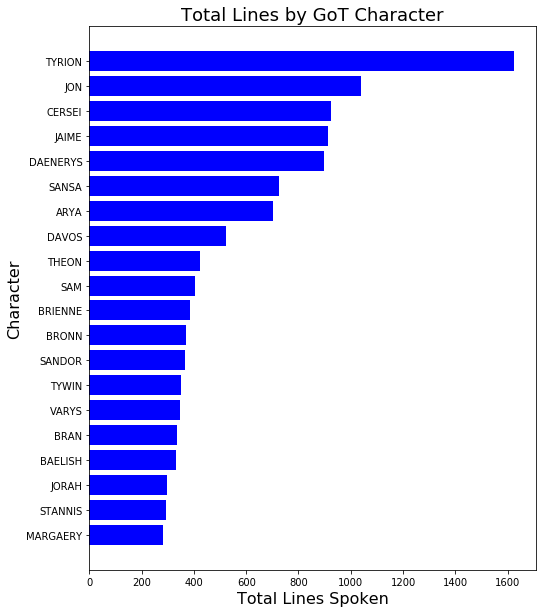

In [1005]:
# Graph total lines per character
max_chars = 20
df_by_char.sort_values(by="Total Lines", ascending=False, inplace=True) # df_by_char is sorted by Lines by default

plt.figure(figsize=(8,10))
plt.barh(width = df_by_char['Total Lines'].values[0:max_chars],\
         y=df_by_char.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Total Lines Spoken', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Total Lines by GoT Character', fontsize=18)
plt.show()

Let's get a sorted series of word counts for each character and graph the number of words spoken for the top 20 most verbose characters.

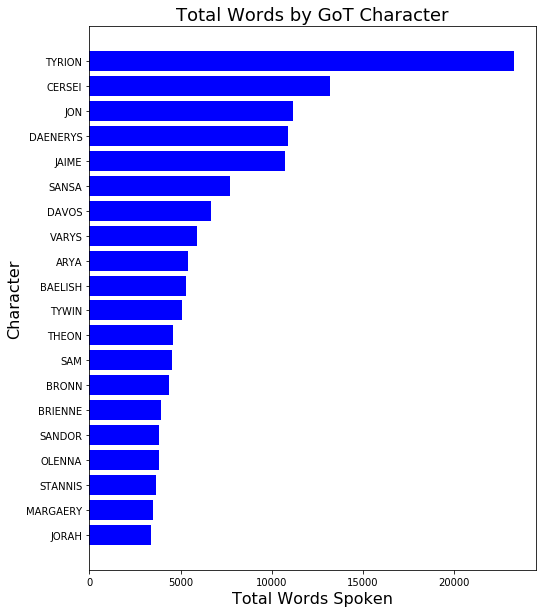

In [1006]:
# Graph total words per character
max_chars = 20
df_by_char.sort_values(by="Total Words", ascending=False, inplace=True) # Re-sort df_by_char by words

plt.figure(figsize=(8,10))
plt.barh(width = df_by_char['Total Words'].values[0:max_chars],\
         y=df_by_char.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Total Words Spoken', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Total Words by GoT Character', fontsize=18)
plt.show()

There's some slight difference here between the two graphs - clearly some characters have more words per lines than others.

Which characters have the most words per line? Let's check the top 50 characters with most lines.

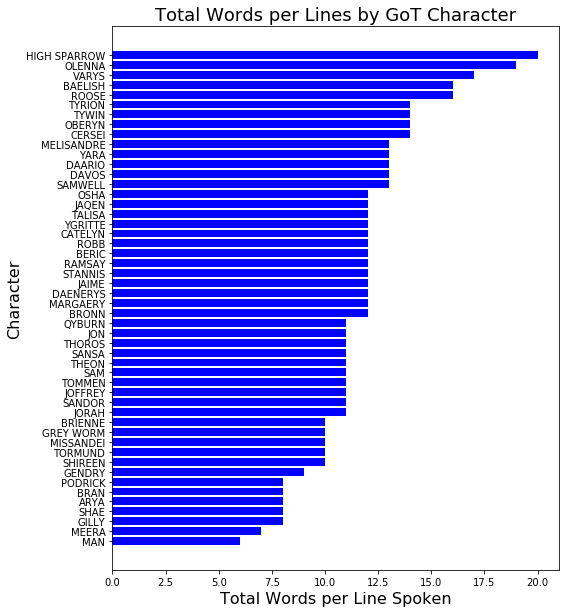

In [1009]:
# Graph total Words per Line for top max_char characters with the most Lines
max_chars=50

df_top_chars = n_most_lines(df, max_chars) # Get top max_chars characters
df_by_char = lines_and_words(df_top_chars) # Get lines & words for characters with most lines
df_by_char.sort_values(by="Words per Line", ascending=False, inplace=True) # Sort by Words per Line

plt.figure(figsize=(8,10))
plt.barh(width = df_by_char['Words per Line'].values[0:max_chars],\
         y=df_by_char.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Total Words per Line Spoken', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Total Words per Lines by GoT Character', fontsize=18)
plt.show()

Let's also have a look at the vocabulary (number of unique unigrams) for each character

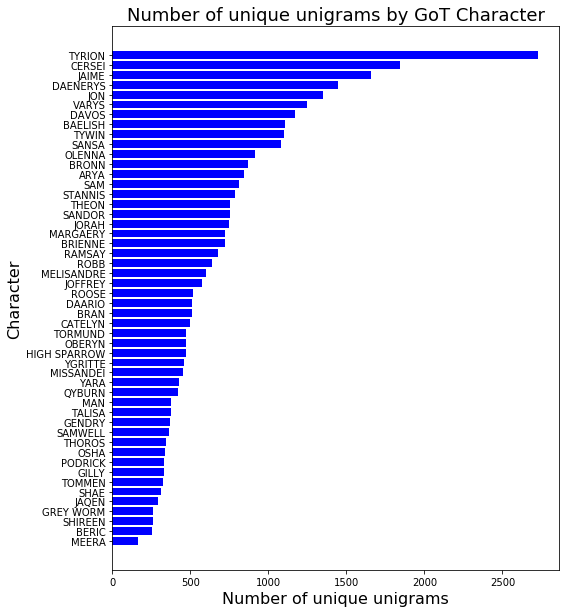

In [1014]:
# Graph Unique_unigrams for max_chars top characters
max_chars=50

df_top_chars = n_most_lines(df, max_chars) # Get top max_chars characters
df_by_char = lines_and_words(df_top_chars) # Get lines & words for characters with most lines
df_by_char.sort_values(by="Num_unique_unigrams", ascending=False, inplace=True) # Sort by Words per Line

plt.figure(figsize=(8,10))
plt.barh(width = df_by_char['Num_unique_unigrams'].values[0:max_chars],\
         y=df_by_char.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Number of unique unigrams', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Number of unique unigrams by GoT Character', fontsize=18)
plt.show()

How about we plot the number of unique unigrams per character by total lines (or words)? That will give us a sense of if more dialogue means more word variance.

In [1024]:
df_by_char.columns

Index(['Total Lines', 'Total Words', 'Unique_unigrams', 'Num_unique_unigrams',
       'Words per Line'],
      dtype='object')

### Start here

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

<Figure size 864x864 with 0 Axes>

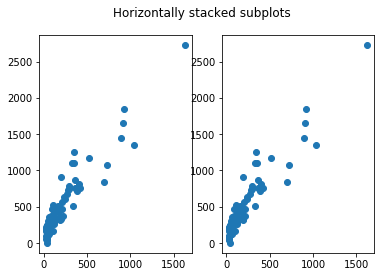

In [1054]:
# Graph Unique_unigrams vs Lines for max_chars top characters
max_chars=100

df_top_chars = n_most_lines(df, max_chars) # Get top max_chars characters
df_by_char = lines_and_words(df_top_chars) # Get lines & words for characters with most lines
df_by_char.sort_values(by="Num_unique_unigrams", ascending=False, inplace=True) # Sort by Words per Line

y = df_by_char['Num_unique_unigrams'].values[0:max_chars]
x = df_by_char['Total Lines'].values[0:max_chars]
names = df_by_char.index.values

fig = plt.figure(figsize=(12,12))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Horizontally stacked subplots')
# ax1.scatter(z, y, fmt='o')

ax1.scatter(x=x, y=y)
ax2.scatter(x=x, y=y)
ax1.xlabel('Total Words', fontsize=16)
ax1.ylabel('Number of unique unigrams', fontsize=16)
ax1.title(f'Number of unique unigrams by total words per GoT Character', fontsize=18)

# List the top 15 names on the plot
for i, txt in enumerate(names[0:15]):
    ax1.annotate(txt, (x[i]+50, y[i]+80))
plt.show()

## 2. Add Sentiment Analysis to df

Now let's run add_sentiment_analysis and explore sentiment by character and episode.

Successfully performed sentiment analysis.


(21709, 10)

In [690]:
# Subset sentiment df by characters with the most lines - use n_most_lines
max_chars = 30
df_sent = n_most_lines(df_sent, max_chars)

In [691]:
# Get mean sentiment for each character
df_sent_by_char = df_sent.groupby("Characters").mean()

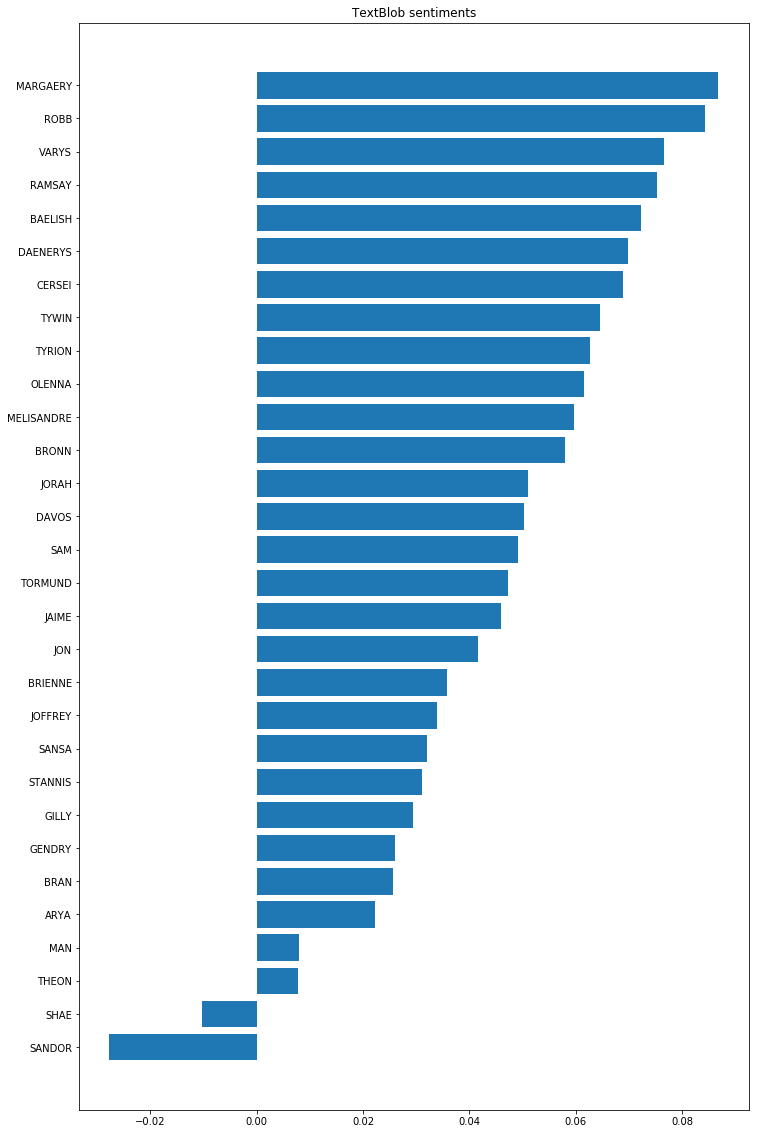

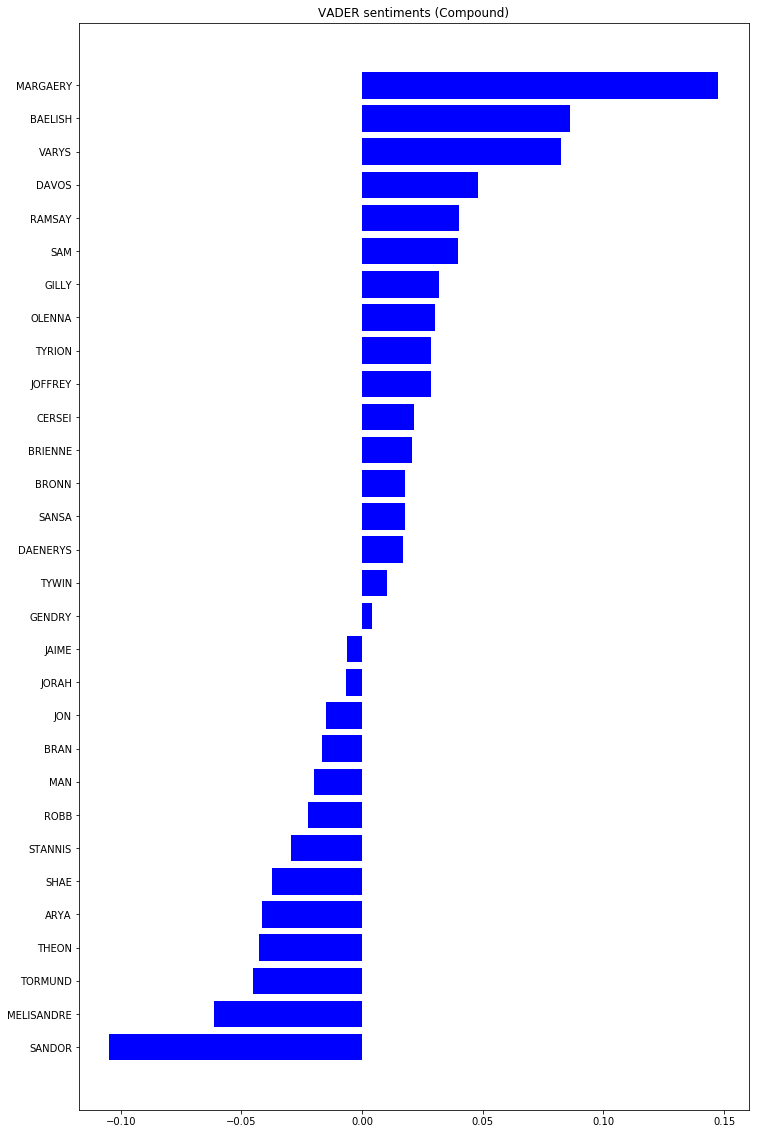

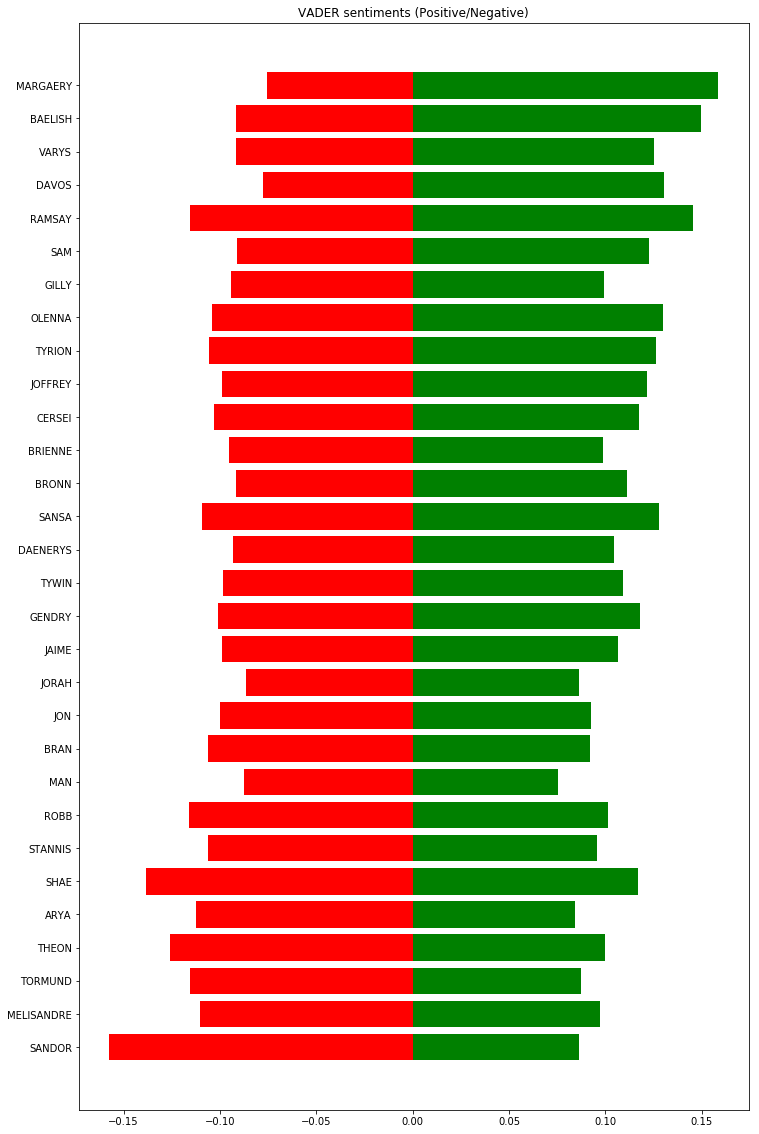

In [692]:
# Graph mean sentiment 
graph_sentiment_by_char(df_sent_by_char)

It looks like Margery Tyrell - all sunshine and roses - is the queen of positive sentiment, while the less-than-friendly Sandor Clegane has the most negative sentiment.

## 3 Generate most common n-grams for each character

Now let's run our add_ngrams function and query our newly updated df via get_ngrams.

In [706]:
# Get the 5 most common n-grams for character
char = "SANDOR"
top_n_grams = get_ngrams(df, char, 10)
top_n_grams[3]

array([[('kill', 'me', 'kill', 'me'), 3],
       [('do', 'you', 'want', 'to'), 2],
       [('the', 'fuck', 'you', 'doing'), 2],
       [('what', 'are', 'you', 'doing'), 2],
       [('get', 'on', 'with', 'it'), 2],
       [('theres', 'plenty', 'worse', 'than'), 2],
       [('plenty', 'worse', 'than', 'me'), 2],
       [('men', 'who', 'like', 'to'), 2],
       [('what', 'do', 'you', 'want'), 2],
       [('fair', 'wages', 'for', 'fair'), 2]], dtype=object)

In [710]:
# Check how many times a phrase is used, who uses it
phrase = "chicken"

# How many times does the phrase appear?
df_temp = df[df['Lines'].str.contains(phrase, case=False)]
print(f"{phrase} is used {len(df_temp)} times")

# Who used the phrase?
display(df_temp.groupby(by='Characters').size().sort_values(ascending=False))

chicken is used 10 times


Characters
SANDOR      5
POLLIVER    2
MANCE       1
GENDRY      1
ARYA        1
dtype: int64

# 4. Plot averaged (2 eps avg?) quantity /sentiment of dialogue over the series

## 5. Machine Learning

### Use a random forest or XGBoost for a classificaiton model?
- One-hot encode all words (minus stopwords) like for cannabis NLP? Reduce dimensionality by most common?
- Examine most distinct n-grams (mutual information / entropy?)
- Analyze which words/phrases are the most significant?
- Compare model success rates to a less-interpretable (but possibly higher accuracy) neural network?

### Cluster based on terms used? Look at splits in the clusters?
- Analyze term significance by frequency of terms in each cluster? Check previous work.

How many distinct words does each character use? We can also normalize this by the total number of lines or words they utter.

In [717]:
df_temp = lines_and_words(df)

     Characters                                              Lines  Season  \
0  WAYMAR ROYCE  What d’you expect? They’re savages. One lot st...       1   

   Episode  Words  Polarity  Positive  Negative  Neutral  Compound  \
0        1     24    -0.125       0.0     0.242    0.758    -0.772   

                                            Unigrams  \
0  [dyou, expect, theyre, savages, lot, steals, g...   

                                             Bigrams  \
0  [(what, dyou), (dyou, expect), (expect, theyre...   

                                            Trigrams  \
0  [(what, dyou, expect), (dyou, expect, theyre),...   

                                           Fourgrams  \
0  [(what, dyou, expect, theyre), (dyou, expect, ...   

                                           Fivegrams  
0  [(what, dyou, expect, theyre, savages), (dyou,...  
[[['youre' 47]
  ['like' 32]
  ['dont' 31]
  ['im' 24]
  ['fuck' 21]
  ['dead' 21]
  ['got' 16]
  ['fucking' 16]
  ['thats' 16]
  ['want' 15

In [719]:
top_n_grams

array([[['youre', 47],
        ['like', 32],
        ['dont', 31],
        ['im', 24],
        ['fuck', 21],
        ['dead', 21],
        ['got', 16],
        ['fucking', 16],
        ['thats', 16],
        ['want', 15]],

       [[('in', 'the'), 10],
        [('i', 'dont'), 10],
        [('if', 'you'), 9],
        [('do', 'you'), 8],
        [('you', 'want'), 8],
        [('you', 'dont'), 8],
        [('you', 'think'), 7],
        [('are', 'you'), 7],
        [('kill', 'me'), 7],
        [('go', 'on'), 7]],

       [[('do', 'you', 'want'), 4],
        [('look', 'at', 'me'), 4],
        [('what', 'are', 'you'), 4],
        [('is', 'that', 'it'), 4],
        [('you', 'think', 'youre'), 3],
        [('you', 'want', 'to'), 3],
        [('are', 'you', 'doing'), 3],
        [('worse', 'than', 'me'), 3],
        [('on', 'your', 'own'), 3],
        [('we', 'ask', 'the'), 3]],

       [[('kill', 'me', 'kill', 'me'), 3],
        [('do', 'you', 'want', 'to'), 2],
        [('the', 'fuck', 'you',

In [737]:
# Get the set of unique unigrams uttered by each character
character= "YGRITTE"
unique_words = set(df[df['Characters']==character]["Unigrams"].values.sum())
unique_words

{'afraid',
 'angry',
 'anybodys',
 'armies',
 'arrow',
 'arrows',
 'arse',
 'ass',
 'aye',
 'baby',
 'backside',
 'bald',
 'balls',
 'banging',
 'banners',
 'barely',
 'bastard',
 'bath',
 'bear',
 'beginning',
 'bet',
 'betray',
 'better',
 'big',
 'black',
 'blacken',
 'blood',
 'blushing',
 'bone',
 'bones',
 'bony',
 'boy',
 'boys',
 'brave',
 'break',
 'brothers',
 'brought',
 'bruise',
 'bruised',
 'build',
 'builders',
 'built',
 'burn',
 'cabin',
 'came',
 'cant',
 'care',
 'carry',
 'castle',
 'castles',
 'catch',
 'cause',
 'cave',
 'chance',
 'chose',
 'claw',
 'close',
 'clouds',
 'club',
 'cock',
 'cold',
 'collapse',
 'color',
 'come',
 'comfortable',
 'coming',
 'commands',
 'common',
 'coughing',
 'couldnt',
 'count',
 'course',
 'crow',
 'crows',
 'cut',
 'daddy',
 'day',
 'dead',
 'death',
 'debt',
 'decide',
 'desert',
 'didnt',
 'die',
 'different',
 'dont',
 'dozen',
 'dress',
 'dressed',
 'dresses',
 'drummers',
 'drums',
 'dull',
 'dumb',
 'em',
 'eye',
 'eyes',


In [735]:
# Apply n_most_lines, lines_and_words, to generate a df of the characters with the most lines. 
max_chars = 1000

df_top_chars = n_most_lines(df, max_chars)
df_by_char = lines_and_words(df_top_chars)

,Total Lines,Total Words,Words per Line
VARYS,348,5930,17.0
BAELISH,333,5323,16.0
TYRION,1626,23313,14.0
CERSEI,923,13224,14.0
TYWIN,351,5085,14.0
DAVOS,521,6651,13.0
BRONN,368,4348,12.0
STANNIS,295,3671,12.0
MARGAERY,282,3512,12.0
DAENERYS,898,10889,12.0


In [739]:
df['Unique_words'] = df['Unigrams'].values.sum()

KeyboardInterrupt: 

In [ ]:
df['Unique_words'].head()

In [740]:
# Generate lines & words df to be added to 
df_by_char = lines_and_words(df)

In [757]:
df_by_char.loc['TYRION']

Total Lines        1626
Total Words       23313
Words per Line       14
Unique_words           
Name: TYRION, dtype: object

,Total Lines,Total Words,Words per Line
TYRION,1626,23313,14.0
JON,1040,11182,11.0
CERSEI,923,13224,14.0
JAIME,912,10713,12.0
DAENERYS,898,10889,12.0
SANSA,727,7711,11.0
ARYA,701,5415,8.0
DAVOS,521,6651,13.0
THEON,422,4604,11.0
SAM,405,4508,11.0


In [ ]:
# Load df_by_char
df_by_char = pd.read_csv('GoT_NLP data/GoT_by_char.csv', index_col="Unnamed: 0")